Import modules/packages

In [328]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [329]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Make output directory

In [330]:
cwd = os.getcwd()
path = cwd + "\output"
if not os.path.exists(path):
    os.mkdir(path)

Load data and assign response (y) and predictor (X) variables. 

In [331]:
#change file name (GSE49996genedataneg.txt) as needed
#file should contain ranking scores (e.g., T-score, NES, etc.) for items
#file must have column headers (1 for experimental and 0 for control samples) in row 1
#file must have row headers in column A
df = pd.read_csv('GSE49996genedataneg.txt', delimiter = "\t", low_memory=False, header=None)

tempy = list(df.iloc[0])
tempy.pop(0)
y = np.array(tempy)

df = df.transpose()
df = df.reindex(df.index.drop(0)).reset_index(drop=True)
df2 = df.iloc[: , 1:]
querysize = len(df2.columns)
X = np.array(df2.values.tolist())

Assigning training and testing sets then performing LOOCV

In [332]:
k = 5 #change as necessary
groups = np.array([])
for i in range(len(y)):
    groups = np.append(groups, i)
group_kfold = GroupKFold(n_splits=k)
group_kfold.get_n_splits(X, y, groups)

5

In [333]:
dfprob = pd.DataFrame()
dfpredict = pd.DataFrame()
dfcoeff = pd.DataFrame()
xtestvallist = []
acc_score = []
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LogisticRegression(solver='liblinear')
    clf = model.fit(X_train, y_train)
    temppredicted = model.predict(X_test)
    predicted = pd.Series(temppredicted)
    dfpredict = dfpredict.append(predicted, ignore_index=True)
    
    acc = accuracy_score(predicted, y_test)
    acc_score.append(acc)
    avg_acc_score = sum(acc_score)/k
 
    #returns coefficients for each gene in the logistic regression equation
    clfall = clf.coef_ 
    clfall = np.append(clfall, clf.intercept_)
    tempseries = pd.Series(clfall)
    dfcoeff = dfcoeff.append(tempseries, ignore_index=True)
    
    for i in range(len(y_test)):
        #calculates equaton total value
        temptotal = 0
        n = 0
        X_test1 = X_test[i]
        for j in X_test1:
            temptotal = temptotal + (clfall[n] * j)
            n = n + 1
        temptotal = temptotal + clf.intercept_
        xtestvallist.append(float(temptotal))
        
        X_test1 = np.reshape(X_test1, (1, -1))
        tempprobability = model.predict_proba(X_test1)
        tempprobability = tempprobability[0]
        probability = pd.Series(tempprobability)
        dfprob = dfprob.append(probability, ignore_index=True)        
        
        print('Predicted experimental conditions for this sample:', predicted[i])
        print('Actual experimental conditions for this sample:', y_test[i])
        print('Equation value for this sample:', temptotal)
        print('Probability y-axis for this sample is:', probability[0])
        print()
    

print('accuracy of each fold - {}'.format(acc_score))
        
dfpredict.to_csv('output\dfpredictdata.txt', sep='\t', index=True)
dfprob.to_csv('output\dfprobdata.txt', sep='\t', index=False)
dfcoeff.to_csv('output\dfcoeffdata.txt', sep='\t', index=True)
dfcoeffavg = dfcoeff.mean(axis=0)
dfcoeffavg.to_csv('output\dfcoeffavgdata.txt', sep='\t', index=True)

Predicted experimental conditions for this sample: 0.0
Actual experimental conditions for this sample: 0.0
Equation value for this sample: [-0.31372772]
Probability y-axis for this sample is: 0.5777948926099212

Predicted experimental conditions for this sample: 0.0
Actual experimental conditions for this sample: 0.0
Equation value for this sample: [-0.28157092]
Probability y-axis for this sample is: 0.569931312882954

Predicted experimental conditions for this sample: 0.0
Actual experimental conditions for this sample: 0.0
Equation value for this sample: [-4.01359124]
Probability y-axis for this sample is: 0.982252281990293

Predicted experimental conditions for this sample: 0.0
Actual experimental conditions for this sample: 0.0
Equation value for this sample: [-3.10098512]
Probability y-axis for this sample is: 0.9569333620055528

Predicted experimental conditions for this sample: 1.0
Actual experimental conditions for this sample: 0.0
Equation value for this sample: [5.01800751]
Pr

Predicted experimental conditions for this sample: 1.0
Actual experimental conditions for this sample: 1.0
Equation value for this sample: [6.97112757]
Probability y-axis for this sample is: 0.0009377138483429581

Predicted experimental conditions for this sample: 1.0
Actual experimental conditions for this sample: 1.0
Equation value for this sample: [1.41104304]
Probability y-axis for this sample is: 0.19606959409289404

Predicted experimental conditions for this sample: 0.0
Actual experimental conditions for this sample: 1.0
Equation value for this sample: [-0.19336353]
Probability y-axis for this sample is: 0.5481908227702252

Predicted experimental conditions for this sample: 1.0
Actual experimental conditions for this sample: 1.0
Equation value for this sample: [5.49539751]
Probability y-axis for this sample is: 0.004088836901149806

Predicted experimental conditions for this sample: 1.0
Actual experimental conditions for this sample: 1.0
Equation value for this sample: [4.9102855

In [334]:
#reports performance via mean (and stdev) of accurate predicted sample conditions
scores = cross_val_score(model, X, y, groups, cv=group_kfold)
print('Accuracy mean is', np.mean(scores))
print('Accuracy stdev is', np.std(scores))

Accuracy mean is 0.8300653594771241
Accuracy stdev is 0.03326277294117508


Time to visualize the results generated above

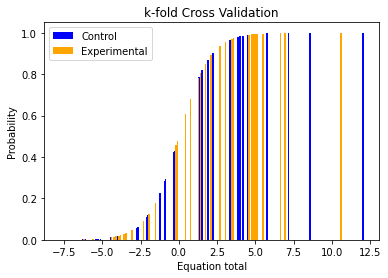

In [335]:
controlXvals = []
expXvals = []
controlYvals = []
expYvals = []
n = 0
for iter in dfprob[1]:
    if y[n] == 0:
        controlXvals.append(xtestvallist[n])
        controlYvals.append(iter)
    if y[n] == 1:
        expXvals.append(xtestvallist[n])
        expYvals.append(iter)
    n = n + 1
   
plt.title("k-fold Cross Validation")
plt.xlabel("Equation total")
plt.ylabel("Probability")
plt.bar(controlXvals, controlYvals, width=0.1, label='Control', color='blue')
plt.bar(expXvals, expYvals, width=0.1, label='Experimental', color='orange')
plt.legend(loc='best')
plt.show()